# Plot citation statistics for CMIP overview publications

In [1]:
# Updates
# PJD  5 Apr 2023 - Started
# PJD 13 Apr 2023 - Updated citation counts
# PJD 14 Apr 2023 - Augmented to include comparison models (CCSM4, CESM1, CESM2, E3SM-1-0)
# PJD 14 Apr 2023 - Augmented to consider all CMIP6 MIP papers
# PJD 12 Jul 2023 - Add CDRMIP durack1/MIPPlots#1; update all entries
# PJD 12 Jul 2023 - Add Charney 1979 and FANGIO/Cess 1990 durack1/MIPPlots#2
# PJD 26 Jul 2023 - Use per-MIP totals (from 12 Jul) to evaluate CMIP6 contributions
# PJD 14 Aug 2023 - Updated citation counts from WoS
# PJD 15 Aug 2023 - Updated bar plot

# WoS APIs:
# WoS Expanded API required to get citations per year
# https://developer.clarivate.com/apis/wos-starter
# https://developer.clarivate.com/apis

## imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import datetime
import os

## define time info

In [3]:
timeNow = datetime.datetime.now()
timeFormat = timeNow.strftime("%y%m%dT%H%M%S")
print("timeFormat:", timeFormat)

timeFormat: 230815T121127


## define input data

In [4]:
labels = ["AMIP1", "CMIP1", "CMIP2", "CMIP3", "CMIP5", "CMIP6", "CMIP6Composite"]

# Charney National Research Council, 1979 National Academies Press
# 1979 - 2023
# https://doi.org/10.17226/12181
# https://scholar.google.com/scholar?cluster=15553179873625400927&hl=en&as_sdt=0,5, 669 google scholar
charneyGS = 669

# FANGIO Cess et al., 1990 JGR
# 1991 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:A1990EB20200022, 725 web of science
# https://doi.org/10.1029/JD095iD10p16601
# https://scholar.google.com/scholar?cluster=6135992129360534519&hl=en&as_sdt=0,5, 1075 google scholar
fangio = [11, 22, 24, 31, 33, 33, 37, 20, 31, 21, 21, 11, 13, 15, 23, 28, 22, 30, 14, 22, 16, 22,
          20, 27, 21, 19, 23, 18, 27, 19, 26, 12, 10]

# create pad index - based on longest citation length (FANGIO, 1991-)
pad = [np.nan]*len(fangio)
# Year since publication
yrSincePublication = np.arange(0, len(fangio))

# AMIP1 Gates et al., 1992 BAMS
# 1992, 1993 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:A1992KD66500003, 942 web of science
# https://doi.org/10.1175/1520-0477(1992)073<1962:ATAMIP>2.0.CO;2
amip1 = [0, 1, 18, 50, 54, 60, 67, 60, 61, 39, 38, 48, 23, 22, 23, 21, 20, 14, 17, 21, 16,
        21, 25, 27, 33, 22, 27, 27, 25, 23, 21, 18]
amip1a = copy.deepcopy(pad)
amip1a[:len(amip1)] = amip1
amip1 = amip1a
del(amip1a)

# CMIP1 Meehl et al., 1995 BAMS
# 1995, 1996 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:A1995RG21000008, 42 web of science
# https://doi.org/10.1175/1520-0477-76.6.951
cmip1 = [0, 3, 6, 5, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 4, 3, 4]
cmip1a = copy.deepcopy(pad)
cmip1a[:len(cmip1)] = cmip1
cmip1 = cmip1a
del(cmip1a)

# CMIP2 Meehl et al., 2005 BAMS
# 2005 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000226970100024, 241 web of science
# https://doi.org/10.1175/BAMS-86-1-89
# https://scholar.google.com/scholar?cluster=414872318861866058&hl=en&as_sdt=0,5, 354 google scholar
cmip2 = [5, 5, 7, 12, 12, 7, 15, 18, 21, 18, 21, 16, 11, 7, 10, 22, 13, 10, 11]
cmip2a = copy.deepcopy(pad)
cmip2a[:len(cmip2)] = cmip2
cmip2 = cmip2a
del(cmip2a)

# CMIP3 Meehl et al., 2007 BAMS
# 2007 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000250166400004, 2206 web of science
# https://doi.org/10.1175/BAMS-88-9-1383
# https://scholar.google.com/scholar?cluster=10102268002781422381&hl=en&as_sdt=0,5, 3308 google scholar
cmip3 = [3, 28, 100, 131, 188, 265, 315, 206, 187, 145, 121, 104, 87, 108, 69, 68, 40]
cmip3a = copy.deepcopy(pad)
cmip3a[:len(cmip3)] = cmip3
cmip3 = cmip3a
del(cmip3a)

# CMIP5 Taylor et al., 2012 BAMS
# 2012 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000303110900004, 10349 web of science
# https://doi.org/10.1175/BAMS-D-11-00094.1
# https://scholar.google.com/scholar?cluster=6589368678432360376&hl=en&as_sdt=0,5, 14011 google scholar
cmip5 = [98, 503, 619, 838, 919, 1010, 1250, 1290, 1250, 1182, 889, 366]
cmip5a = copy.deepcopy(pad)
cmip5a[:len(cmip5)] = cmip5
cmip5 = cmip5a
del(cmip5a)
cmip5GS = 14011

# CMIP6 Eyring et al., 2016 GMD
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000376937800013, 3931 web of science
# https://doi.org/10.5194/gmd-9-1937-2016
# https://scholar.google.com/scholar?cluster=5319430665468485905&hl=en&as_sdt=0,5, 5436 google scholar
cmip6 = [23, 58, 112, 155, 544, 940, 1308, 791]
cmip6a = copy.deepcopy(pad)
cmip6a[:len(cmip6)] = cmip6
cmip6 = cmip6a
del(cmip6a)
cmip6GS = 5436

# CMIP6 MIPs - https://gmd.copernicus.org/articles/special_issue590.html + CDRMIP
# 2016 - 2023
# aerchemmip - Collins et al., 2017
# 2017 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000395391000001, 139 web of science
# https://doi.org/10.5194/gmd-10-585-2017
aerchemmip = [np.nan, 5, 14, 14, 32, 21, 41, 12]
# c4mip - Jones et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000383844500002, 141 web of science
# https://doi.org/10.5194/gmd-9-2853-2016
c4mip = [2, 6, 7, 16, 34, 32, 31, 13]
# cdrmip - Keller et al., 2018
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000428836100001, 75 web of science
# https://doi.org/10.5194/gmd-11-1133-2018
cdrmip = [np.nan, np.nan, 7, 7, 15, 15, 21, 10]
# cfmip - Webb et al., 2017
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000395187500001, 156 web of science
# https://doi.org/10.5194/gmd-10-359-2017
cfmip = [3, 12, 18, 25, 32, 24, 24, 18]
# cordex - Gutowski et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000387989000001, 222 web of science
# https://doi.org/10.5194/gmd-9-4087-2016
cordex = [1, 6, 19, 30, 45, 48, 45, 28]
# damip - Gillett et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000386585100001, 203 web of science
# https://doi.org/10.5194/gmd-9-3685-2016
damip = [np.nan, 3, 5, 14, 22, 49, 71, 39]
# dcpp - Boer et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000387064200001, 229 web of science
# https://doi.org/10.5194/gmd-9-3751-2016
dcpp = [7, 14, 10, 37, 45, 44, 44, 28]
# dynvarmip - Gerber & Manzini, 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000384624000001, 24 web of science
# https://doi.org/10.5194/gmd-9-3413-2016
dynvarmip = [np.nan, np.nan, 1, 3, 10, 3, 6, 1]
# fafmip - Gregory et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000387988500001, 101 web of science
# https://doi.org/10.5194/gmd-9-3993-2016
fafmip = [np.nan, 3, 10, 15, 26, 11, 25, 11]
# geomip6 - Kravitz et al., 2015
# 2015 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000364326200024, 107 web of science
# https://doi.org/10.5194/gmd-8-3379-2015
geomip6 = [2+10, 7, 19, 10, 12, 11, 21, 15]
# gmmip - Zhou et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000385387800001, 64 web of science
# https://doi.org/10.5194/gmd-9-3589-2016
gmmip = [2, np.nan, 2, 12, 15, 14, 9, 10]
# highresmip - Haarsma et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000388191000002, 514 web of science
# https://doi.org/10.5194/gmd-9-4185-2016
highresmip = [5, 19, 28, 65, 104, 120, 107, 66]
# ismip6 - Nowicki et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000391579600002, 139 web of science
# https://doi.org/10.5194/gmd-9-4521-2016
ismip6 = [3, 13, 15, 22, 36, 22, 16, 12]
# ls3mip - van den Hurk et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000383800400002, 119 web of science
# https://doi.org/10.5194/gmd-9-2809-2016
ls3mip = [1, 13, 16, 17, 17, 24, 20, 11]
# lumip - Lawrence et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000383892800002, 262 web of science
# https://doi.org/10.5194/gmd-9-2973-2016
lumip = [7, 18, 31, 26, 50, 47, 53, 30]
# omip1 - Griffies et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000384321500001, 178 web of science
# https://doi.org/10.5194/gmd-9-3231-2016
omip1 = [3, 9, 15, 16, 32, 32, 41, 30]
# omip2 - Orr et al., 2017
# 2017 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000403231800001, 117 web of science
# https://doi.org/10.5194/gmd-10-2169-2017
omip2 = [2, 4, 6, 20, 24, 27, 26, 8]
# pamip - Smith et al., 2019
# 2019 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000462352700002, 135 web of science
# https://doi.org/10.5194/gmd-12-1139-2019
pamip = [np.nan, np.nan, np.nan, 8, 27, 40, 37, 23]
# pmip4 - Kageyama et al., 2018
# 2018 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000427841800004, 130 web of science
# https://doi.org/10.5194/gmd-11-1033-2018
pmip4 = [np.nan, np.nan, 9, 19, 30, 23, 32, 17]
# rfmip - Pincus et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000385385300001, 142 web of science
# https://doi.org/10.5194/gmd-9-3447-2016
rfmip = [1, 8, 6, 19, 34, 33, 29, 12]
# scenariomip - O'Neill et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000385385700001, 1439 web of science
# https://doi.org/10.5194/gmd-9-3461-2016
scenariomip = [6, 13, 15, 32, 159, 333, 542, 338]
# simip - Notz et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000384624000002, 63 web of science
# https://doi.org/10.5194/gmd-9-3427-2016
simip = [np.nan, 5, 5, 6, 17, 10, 10, 10]
# viacsab - Ruane et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000385386000002, 30 web of science
# https://doi.org/10.5194/gmd-9-3493-2016
viacsab = [2, 3, 4, 6, 6, 5, 4, np.nan]
# volmip - Zanchettin et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000383794200001, 117 web of science
# https://doi.org/10.5194/gmd-9-2701-2016
volmip = [7, 14, 10, 19, 20, 19, 15, 13]
# zecmip - Jones et al., 2019
# # 2019 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000490550000001, 35 web of science
# https://doi.org/10.5194/gmd-12-4375-2019
zecmip = [np.nan, np.nan, np.nan, 1, 10, 10, 12, 2]

# E3SM-1-0 Golaz et al., 2019 JAMES
# 2019 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000480282800012, 306 web of science
# https://doi.org/10.1029/2018MS001603
# https://doi.org/10.1029/2019MS001870 - Caldwell et al., 2019 high resolution ~74 citations
e3sm1_0 = [30, 74, 79, 79, 44]
e3sm1_0a = copy.deepcopy(pad)
e3sm1_0a[:len(e3sm1_0)] = e3sm1_0
e3sm1_0 = e3sm1_0a
del(e3sm1_0a)

# E3SM-2-0 Golaz et al., 2022 JAMES
# 2022-2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000924492900001, 13 web of science
# https://doi.org/10.1029/2022MS003156
#e3sm2_0 = [3, 10]

# CCSM4 Gent et al., 2011 JCL
# 2011 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000295905400001, 2095 web of science
# https://doi.org/10.1175/2011JCLI4083.1
ccsm4 = [9, 84, 152, 181, 173, 221, 194, 213, 225, 217, 192, 163, 71]
ccsm4a = copy.deepcopy(pad)
ccsm4a[:len(ccsm4)] = ccsm4
ccsm4 = ccsm4a
del(ccsm4a)

# CESM1 Hurrell et al., 2013 BAMS
# 2013 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000325135100007, 1713 web of science
# https://doi.org/10.1175/BAMS-D-12-00121.1
cesm1 = [3, 46, 68, 126, 161, 212, 238, 257, 259, 223, 120]
cesm1a = copy.deepcopy(pad)
cesm1a[:len(cesm1)] = cesm1
cesm1 = cesm1a
del(cesm1a)

# CESM2 Danabasoglu et al., 2020 JAMES
# 2020 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000519728500010, 678 web of science
# https://doi.org/10.1029/2019MS001916
cesm2 = [79, 178, 251, 170]
cesm2a = copy.deepcopy(pad)
cesm2a[:len(cesm2)] = cesm2
cesm2 = cesm2a
del(cesm2a)

# Prints
print("Grey literature uptick? (Google Scholar/Web of Science)")
print("Taylor et al., 2012:", cmip5GS/np.nansum(cmip5))
print("Eyring et al., 2016:", cmip6GS/np.nansum(cmip6))
print()
print("yrSincePublication:", yrSincePublication)
print("fangio:", fangio)
print("amip1:", amip1)
print("cmip1:", cmip1)
print("cmip2:", cmip2)
print("cmip3:", cmip3)
print("cmip5:", cmip5)
print("cmip6:", cmip6)

Grey literature uptick? (Google Scholar/Web of Science)
Taylor et al., 2012: 1.3717446641864108
Eyring et al., 2016: 1.3828542355634699

yrSincePublication: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
fangio: [11, 22, 24, 31, 33, 33, 37, 20, 31, 21, 21, 11, 13, 15, 23, 28, 22, 30, 14, 22, 16, 22, 20, 27, 21, 19, 23, 18, 27, 19, 26, 12, 10]
amip1: [0, 1, 18, 50, 54, 60, 67, 60, 61, 39, 38, 48, 23, 22, 23, 21, 20, 14, 17, 21, 16, 21, 25, 27, 33, 22, 27, 27, 25, 23, 21, 18, nan]
cmip1: [0, 3, 6, 5, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 4, 3, 4, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
cmip2: [5, 5, 7, 12, 12, 7, 15, 18, 21, 18, 21, 16, 11, 7, 10, 22, 13, 10, 11, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
cmip3: [3, 28, 100, 131, 188, 265, 315, 206, 187, 145, 121, 104, 87, 108, 69, 68, 40, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
cmip5: [98, 5

## first plot - MIPs only

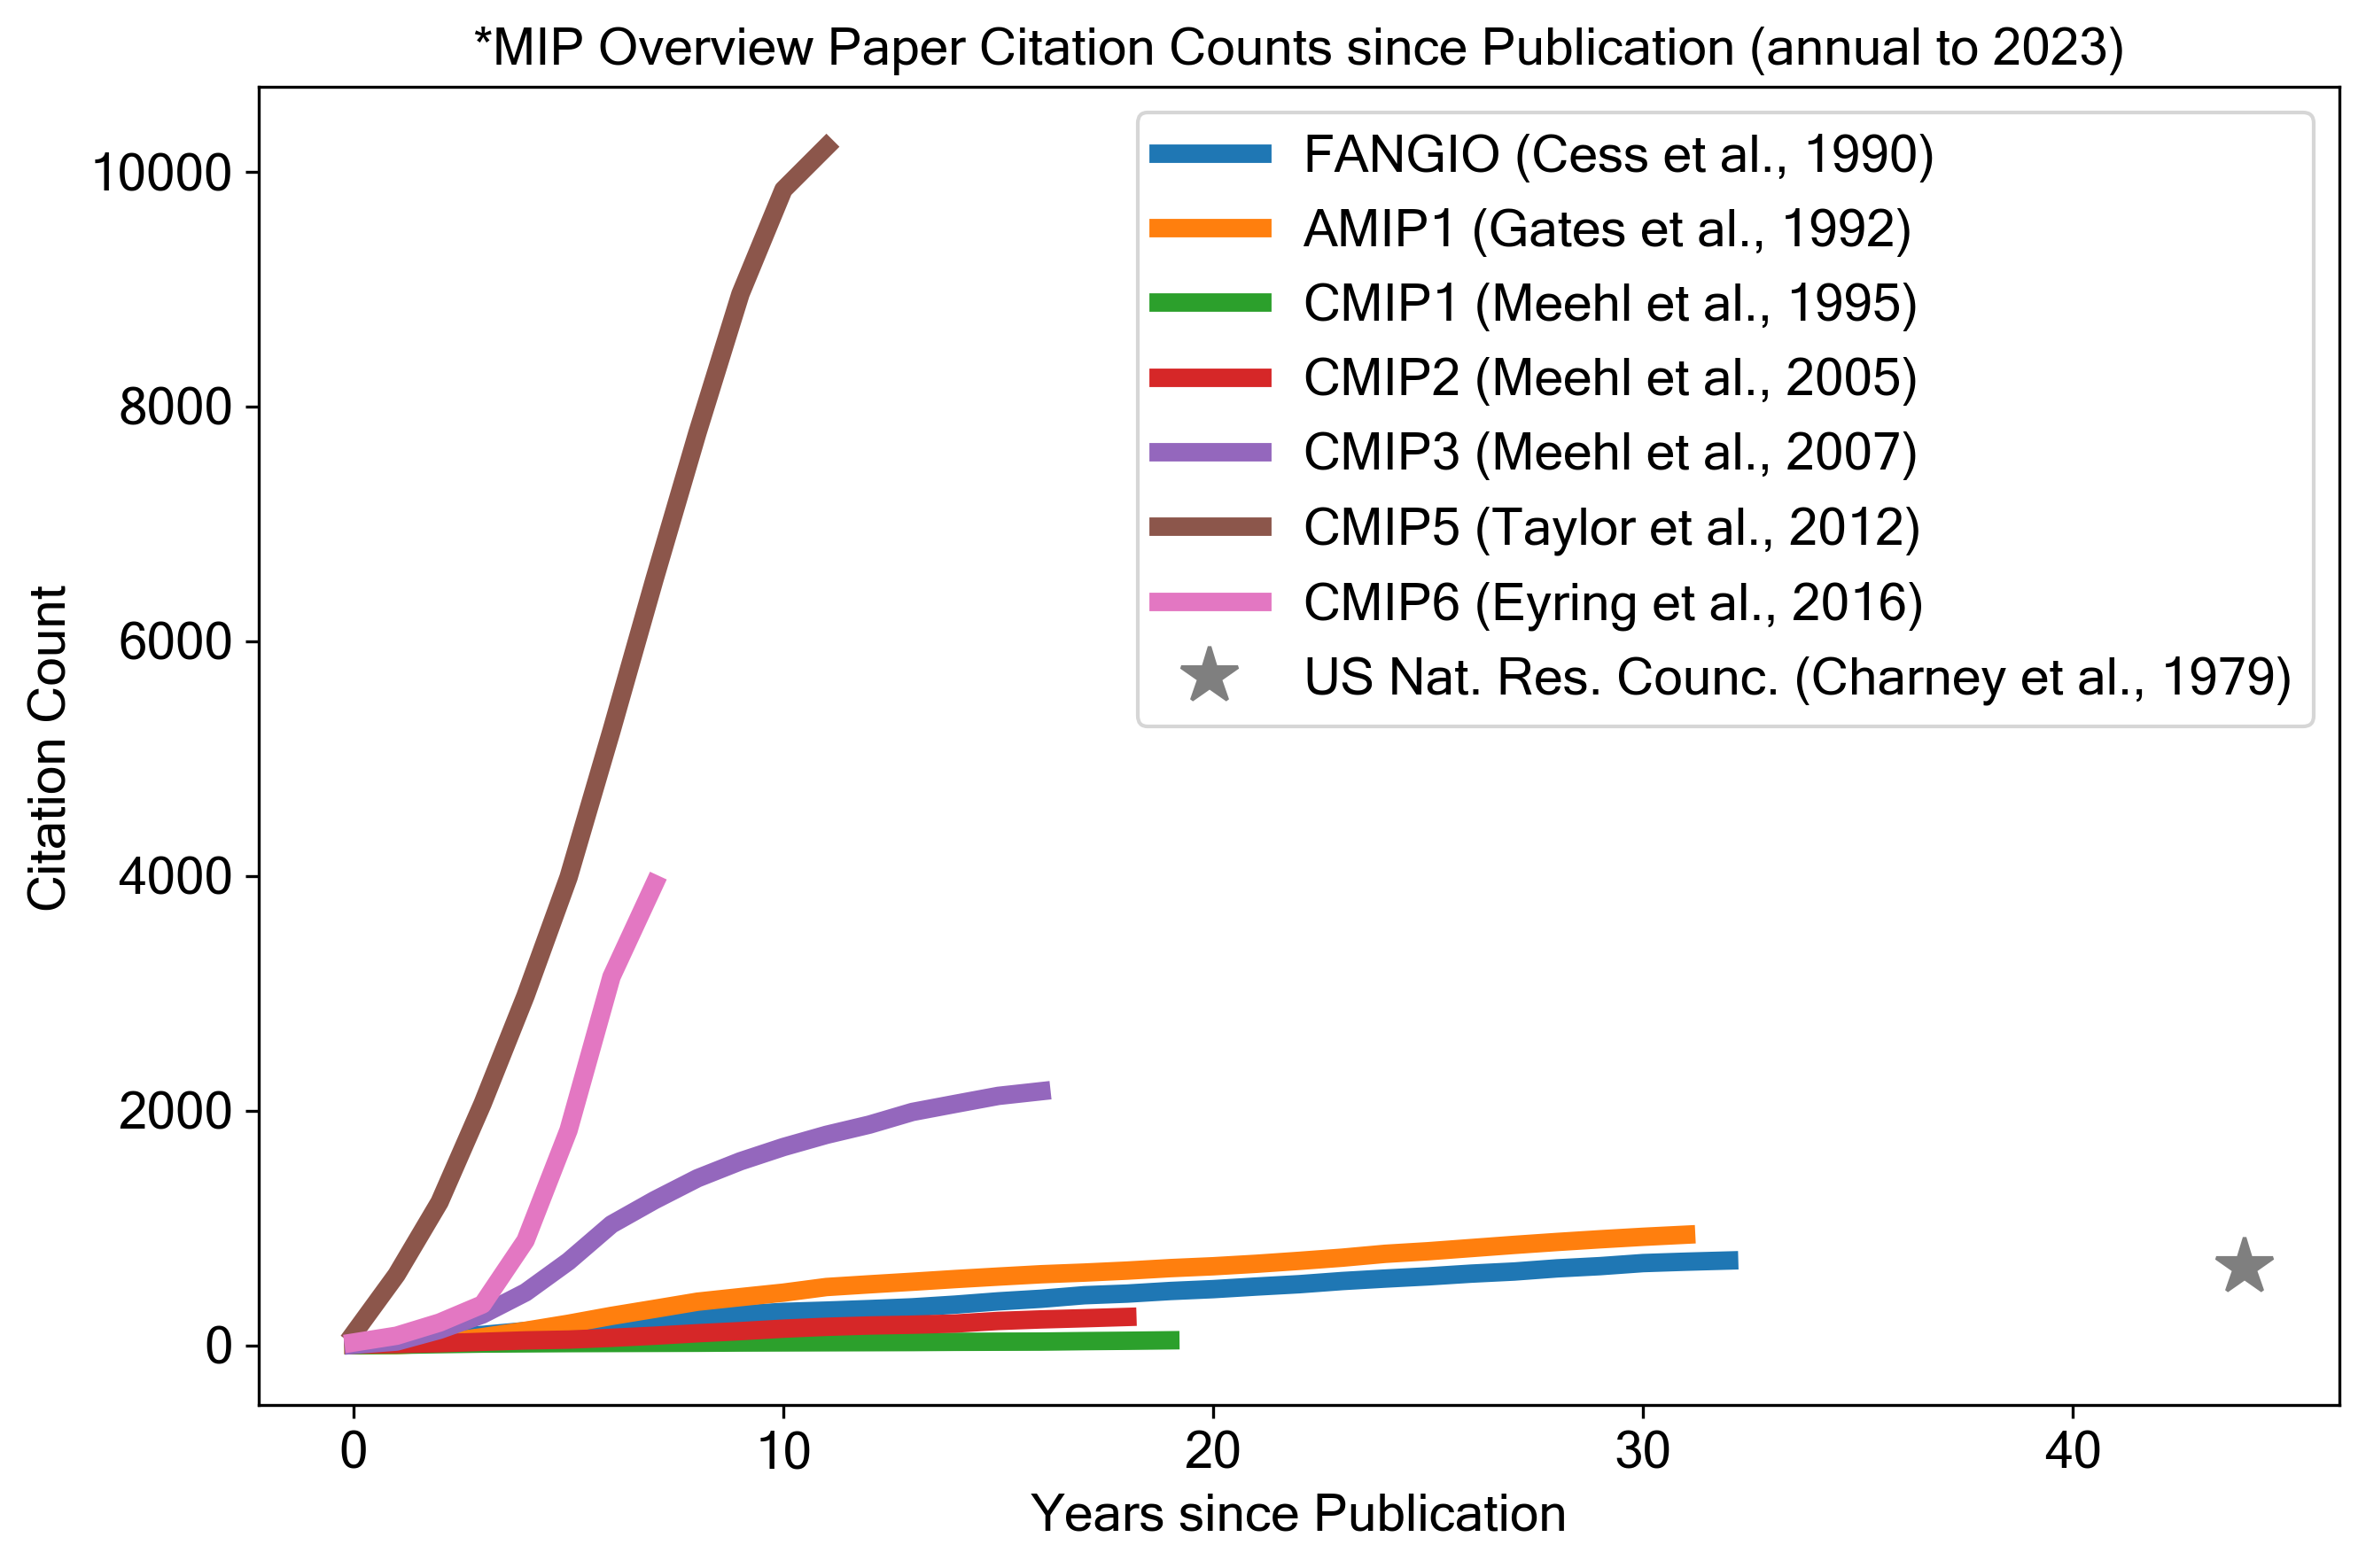

In [5]:
# set inputs
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars
fontsize = 14
lineWidth = 5
fontName = "Microsoft Sans Serif"

# initialize canvas
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# plot from year 1
line0 = plt.plot(yrSincePublication, np.cumsum(fangio), linewidth=lineWidth, label="FANGIO (Cess et al., 1990)")
line1 = plt.plot(yrSincePublication, np.cumsum(amip1), linewidth=lineWidth, label="AMIP1 (Gates et al., 1992)")
line2 = plt.plot(yrSincePublication, np.cumsum(cmip1), linewidth=lineWidth, label="CMIP1 (Meehl et al., 1995)")
line3 = plt.plot(yrSincePublication, np.cumsum(cmip2), linewidth=lineWidth, label="CMIP2 (Meehl et al., 2005)")
line4 = plt.plot(yrSincePublication, np.cumsum(cmip3), linewidth=lineWidth, label="CMIP3 (Meehl et al., 2007)")
line5 = plt.plot(yrSincePublication, np.cumsum(cmip5), linewidth=lineWidth, label="CMIP5 (Taylor et al., 2012)")
line6 = plt.plot(yrSincePublication, np.cumsum(cmip6), linewidth=lineWidth, label="CMIP6 (Eyring et al., 2016)")
star0 = plt.plot(2023-1979, charneyGS, marker="*", markersize=16, linestyle="None", label="US Nat. Res. Counc. (Charney et al., 1979)")

# pretty things up - add text for labels, title and custom x-axis tick labels, etc.
ax.set_title('*MIP Overview Paper Citation Counts since Publication (annual to 2023)',
             fontname=fontName, fontsize=fontsize)
ax.set_ylabel('Citation Count', fontname=fontName, fontsize=fontsize)
plt.yticks(fontname=fontName, fontsize=fontsize)
ax.set_xlabel("Years since Publication", fontname=fontName, fontsize=fontsize)
plt.xticks(fontname=fontName, fontsize=fontsize)
ax.legend(prop={"family": fontName, "size": fontsize})

# fill canvas
fig.tight_layout()

# display, save and close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-1.png"]))

## second plot (a) - Contributing MIPs - line plot

actLabels: 25 ['AerChemMIP (Collins et al., 2017); 139', 'C4MIP (Jones et al., 2016); 141', 'CDRMIP (Keller et al., 2018); 75', 'CFMIP (Webb et al., 2017); 156', 'CORDEX (Gutowski et al., 2016); 222', 'DAMIP (Gillett et al., 2016); 203', 'DCPP (Boer et al., 2016); 229', 'DynVarMIP (Gerber & Manzini, 2016); 24', 'FAFMIP (Gregory et al., 2016); 101', 'GeoMIP6 (Kravitz et al., 2015); 107', 'GMMIP (Zhou et al., 2016); 64', 'HighResMIP (Haarsma et al., 2016); 514', 'ISMIP6 (Nowicki et al., 2016); 139', 'LS3MIP (va den Hurk et al., 2016); 119', 'LUMIP (Lawrence et al., 2016); 262', 'OMIP-Phys. (Griffies et al., 2016); 178', 'OMIP-BioGeoChem. (Orr et al., 2017); 117', 'PAMIP (Smith et al., 2019); 135', 'PMIP4 (Kageyama et al., 2018); 130', 'RFMIP (Pincus et al., 2016); 142', "ScenarioMIP (O'Neill et al., 2016); 1438", 'SIMIP (Notz et al., 2016); 63', 'VIACS AB (Ruane et al., 2016); 30', 'VolMIP (Zanchettin et al., 2016); 117', 'ZECMIP (Jones et al., 2019); 35']
mip: [nan, 5, 14, 14, 32, 21, 4

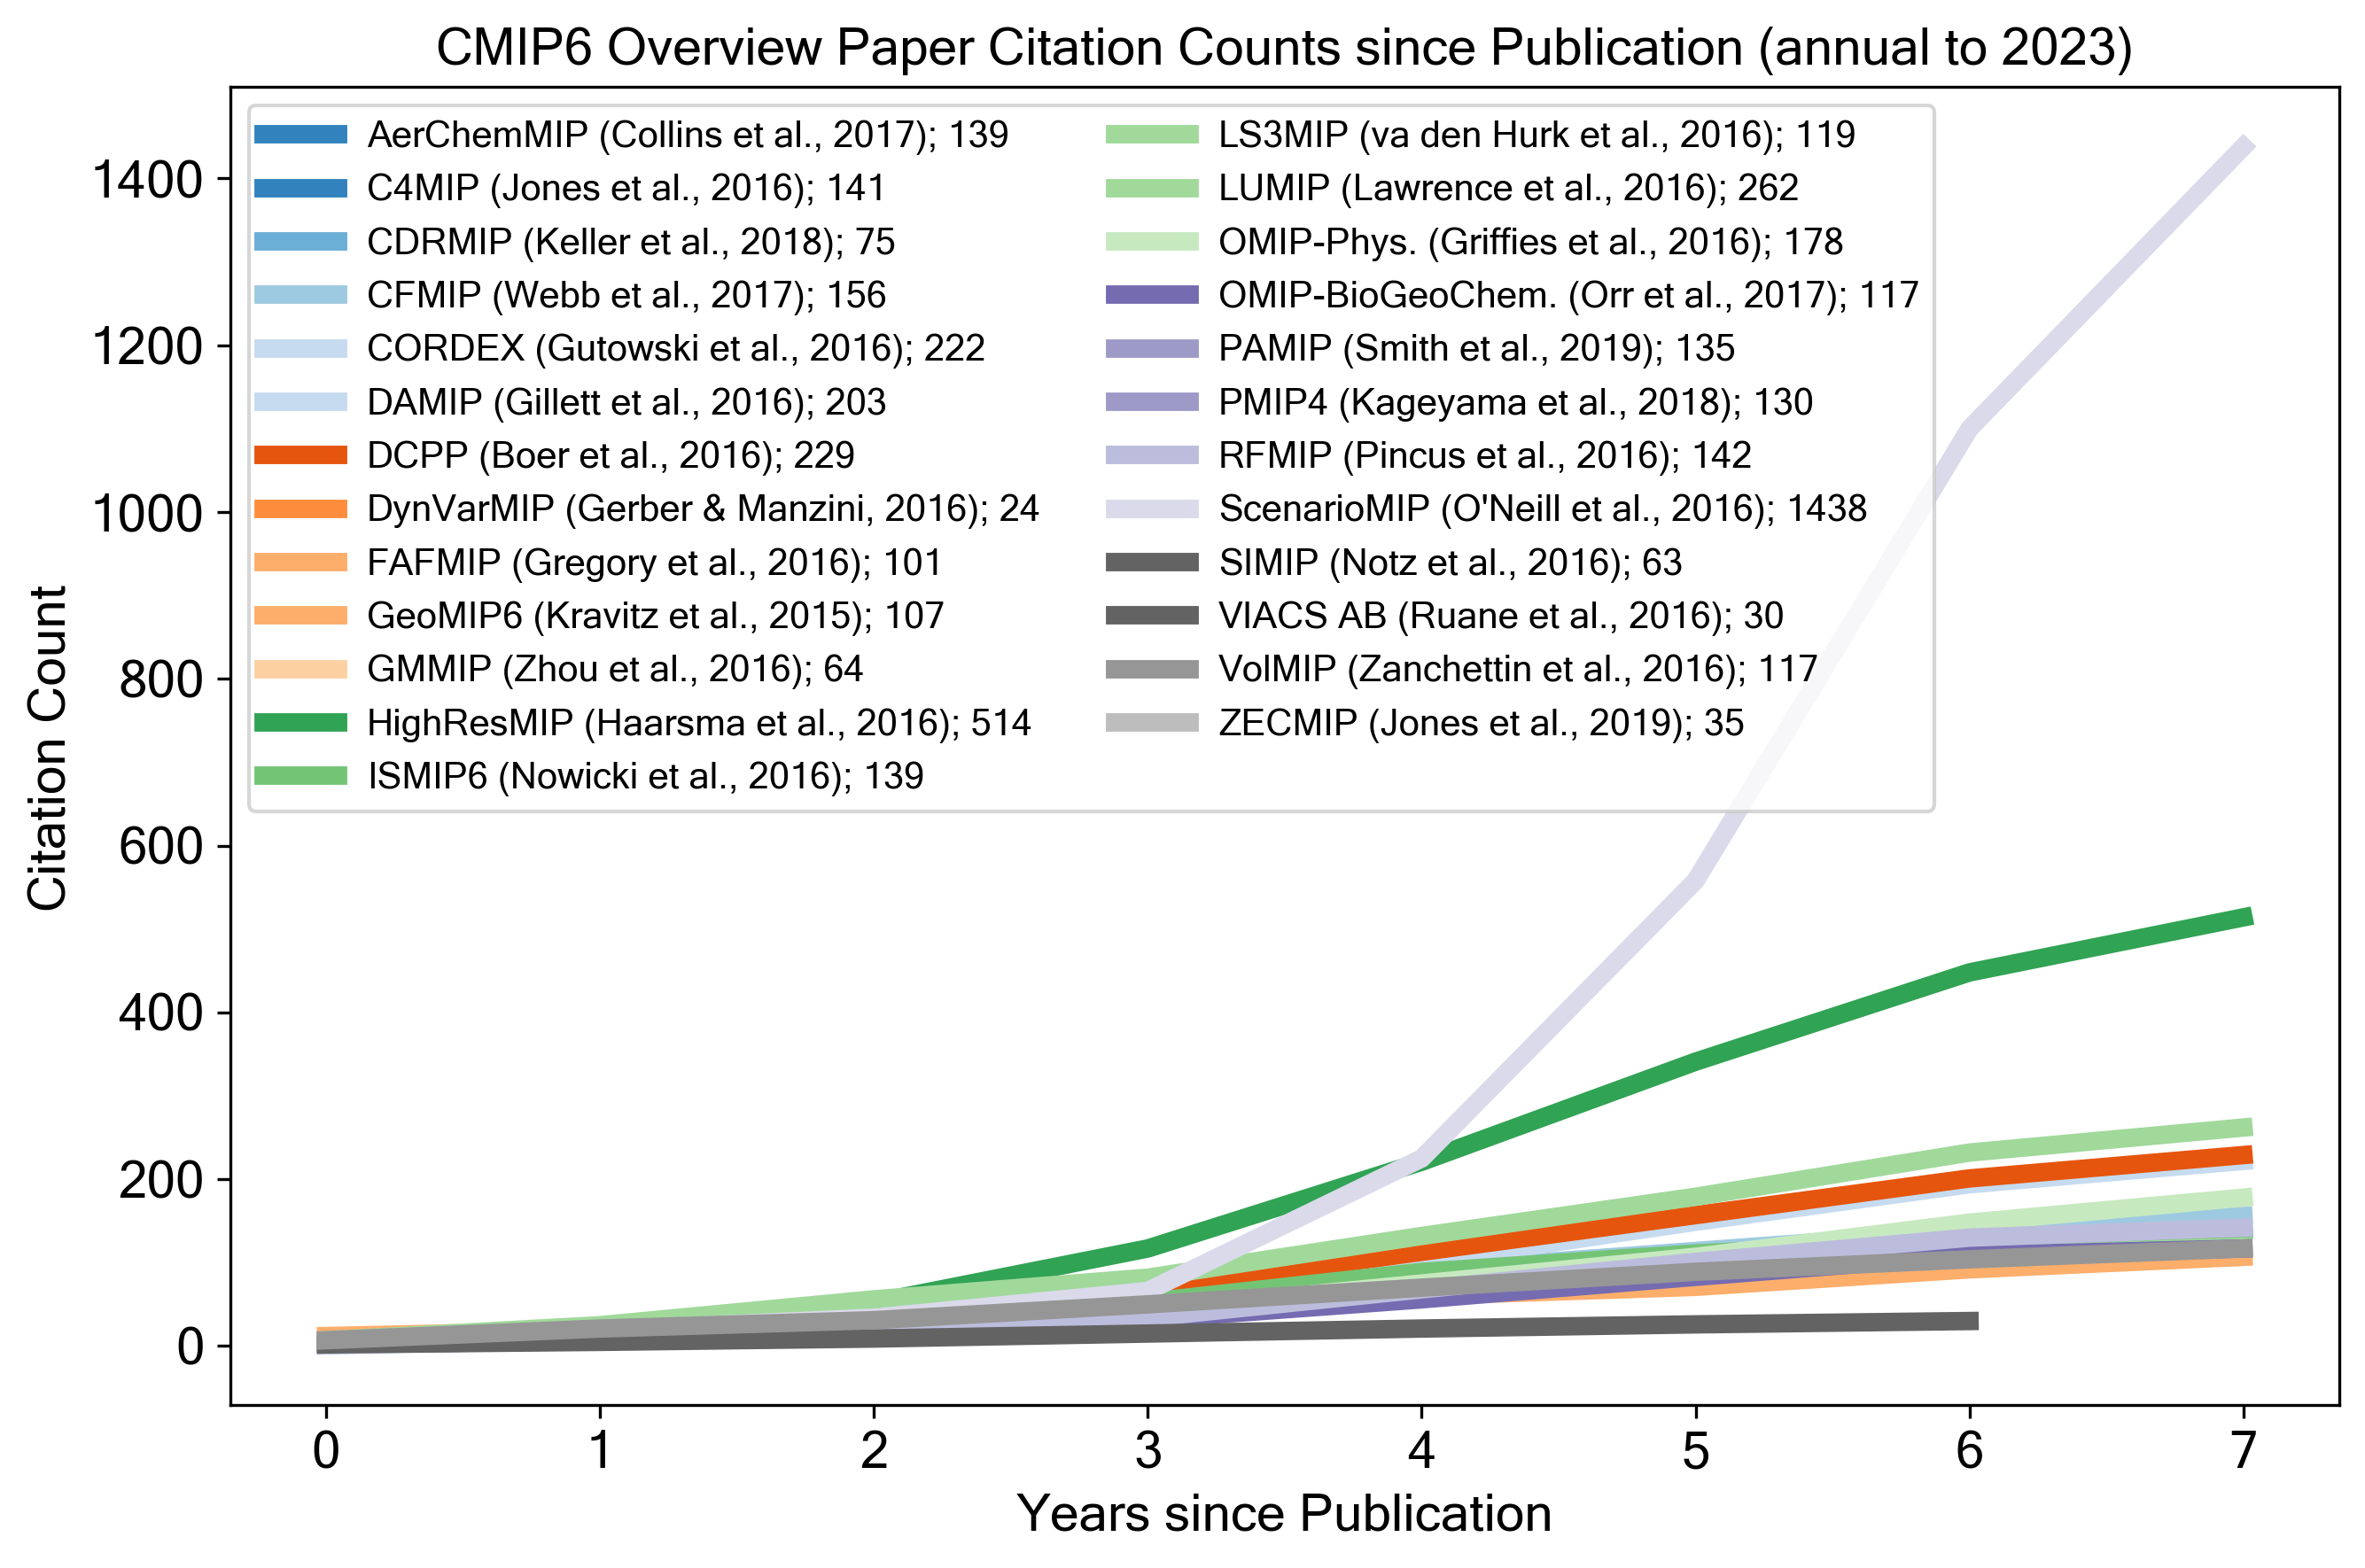

In [6]:
# Generate CMIP6 and per MIP
cmip6Comp = np.cumsum([aerchemmip, c4mip, cdrmip, cfmip, cordex, damip, dcpp, dynvarmip, fafmip, geomip6, gmmip,
                       highresmip, ismip6, ls3mip, lumip, omip1, omip2, pamip, pmip4, rfmip, scenariomip,
                       simip, viacsab, volmip, zecmip], 0)
#cmip6Compa = copy.deepcopy(pad)
#cmip6Compa[:len(cmip6Comp)] = cmip6Comp
#cmip6Comp = cmip6Compa
#del(cmip6Compa)
#cmip6CompA = np.nansum([cmip6, cmip6Comp], 0)
#cmip6CompA = np.where(cmip6CompA == 0., np.nan, cmip6CompA)

# Year since publication
yrSincePublication2 = np.arange(0, len(aerchemmip))

# set inputs
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars
fontsize = 14
lineWidth = 5
fontName = "Microsoft Sans Serif"
NUM_COLORS = 26
colList = []
cm = plt.get_cmap('tab20c')  # also tab 20b, tab20
for i in range(NUM_COLORS):
    colList.append(cm(1.*i/NUM_COLORS))
# string format
f = "{:0.0f}"
    
# create labels
actLabels = []
#actLabels.append('; '.join(["CMIP6 (Eyring et al., 2016)", f.format(np.nansum(cmip6))]))
#actLabels.append('; '.join(["CMIP6 (Composite 2015-)", f.format(np.nansum(cmip6Comp))]))
actLabels.append('; '.join(["AerChemMIP (Collins et al., 2017)", f.format(np.nansum(aerchemmip))]))
actLabels.append('; '.join(["C4MIP (Jones et al., 2016)", f.format(np.nansum(c4mip))]))
actLabels.append('; '.join(["CDRMIP (Keller et al., 2018)", f.format(np.nansum(cdrmip))]))
actLabels.append('; '.join(["CFMIP (Webb et al., 2017)", f.format(np.nansum(cfmip))]))
actLabels.append('; '.join(["CORDEX (Gutowski et al., 2016)", f.format(np.nansum(cordex))]))
actLabels.append('; '.join(["DAMIP (Gillett et al., 2016)", f.format(np.nansum(damip))]))
actLabels.append('; '.join(["DCPP (Boer et al., 2016)", f.format(np.nansum(dcpp))]))
actLabels.append('; '.join(["DynVarMIP (Gerber & Manzini, 2016)", f.format(np.nansum(dynvarmip))]))
actLabels.append('; '.join(["FAFMIP (Gregory et al., 2016)", f.format(np.nansum(fafmip))]))
actLabels.append('; '.join(["GeoMIP6 (Kravitz et al., 2015)", f.format(np.nansum(geomip6))]))
actLabels.append('; '.join(["GMMIP (Zhou et al., 2016)", f.format(np.nansum(gmmip))]))
actLabels.append('; '.join(["HighResMIP (Haarsma et al., 2016)", f.format(np.nansum(highresmip))]))
actLabels.append('; '.join(["ISMIP6 (Nowicki et al., 2016)", f.format(np.nansum(ismip6))]))
actLabels.append('; '.join(["LS3MIP (va den Hurk et al., 2016)", f.format(np.nansum(ls3mip))]))
actLabels.append('; '.join(["LUMIP (Lawrence et al., 2016)", f.format(np.nansum(lumip))]))
actLabels.append('; '.join(["OMIP-Phys. (Griffies et al., 2016)", f.format(np.nansum(omip1))]))
actLabels.append('; '.join(["OMIP-BioGeoChem. (Orr et al., 2017)", f.format(np.nansum(omip2))]))
actLabels.append('; '.join(["PAMIP (Smith et al., 2019)", f.format(np.nansum(pamip))]))
actLabels.append('; '.join(["PMIP4 (Kageyama et al., 2018)", f.format(np.nansum(pmip4))]))
actLabels.append('; '.join(["RFMIP (Pincus et al., 2016)", f.format(np.nansum(rfmip))]))
actLabels.append('; '.join(["ScenarioMIP (O'Neill et al., 2016)", f.format(np.nansum(scenariomip))]))
actLabels.append('; '.join(["SIMIP (Notz et al., 2016)", f.format(np.nansum(simip))]))
actLabels.append('; '.join(["VIACS AB (Ruane et al., 2016)", f.format(np.nansum(viacsab))]))
actLabels.append('; '.join(["VolMIP (Zanchettin et al., 2016)", f.format(np.nansum(volmip))]))
actLabels.append('; '.join(["ZECMIP (Jones et al., 2019)", f.format(np.nansum(zecmip))]))
print("actLabels:", len(actLabels), actLabels)
                 
# initialize canvas
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

#cmip6, cmip6Comp, 
mips = [aerchemmip, c4mip, cdrmip, cfmip, cordex, damip, dcpp, dynvarmip, fafmip, geomip6, gmmip,
        highresmip, ismip6, ls3mip, lumip, omip1, omip2, pamip, pmip4, rfmip, scenariomip,
        simip, viacsab, volmip, zecmip]

# plot from year 1
for count, mip in enumerate(mips):
    print("mip:", mip)
    plt.plot(yrSincePublication2, np.cumsum(mip), linewidth=lineWidth, label=actLabels[count], color=colList[count])

# pretty things up - add text for labels, title and custom x-axis tick labels, etc.
ax.set_title('CMIP6 Overview Paper Citation Counts since Publication (annual to 2023)',
             fontname=fontName, fontsize=fontsize)
ax.set_ylabel('Citation Count', fontname=fontName, fontsize=fontsize)
plt.yticks(fontname=fontName, fontsize=fontsize)
ax.set_xlabel("Years since Publication", fontname=fontName, fontsize=fontsize)
plt.xticks(fontname=fontName, fontsize=fontsize)
ax.legend(prop={"family": fontName, "size": 10}, loc="upper left", ncol=2)

# fill canvas
fig.tight_layout()

# display, save and close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-2a.png"]))

## second plot (b) - Contributing MIPs - bar plot

valsum: [139.0, 141, 75.0, 156, 222, 203.0, 229, 24.0, 101.0, 107, 64.0, 514, 139, 119, 262, 178, 117, 135.0, 130.0, 142, 1438, 63.0, 30.0, 117, 35.0]
len(valsum): 25 ; len(labs): 25


/var/folders/7d/rkhc67xs5w70chjmlrr6pv440017ch/T/ipykernel_4796/888393666.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.axes.axes.set_yticklabels(ax1.get_yticklabels(), fontsize=fontSize, fontname=fontname)
/var/folders/7d/rkhc67xs5w70chjmlrr6pv440017ch/T/ipykernel_4796/888393666.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.axes.axes.set_yticklabels(ax2.get_yticklabels(), fontsize=fontSize, fontname=fontname)
/var/folders/7d/rkhc67xs5w70chjmlrr6pv440017ch/T/ipykernel_4796/888393666.py:87: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


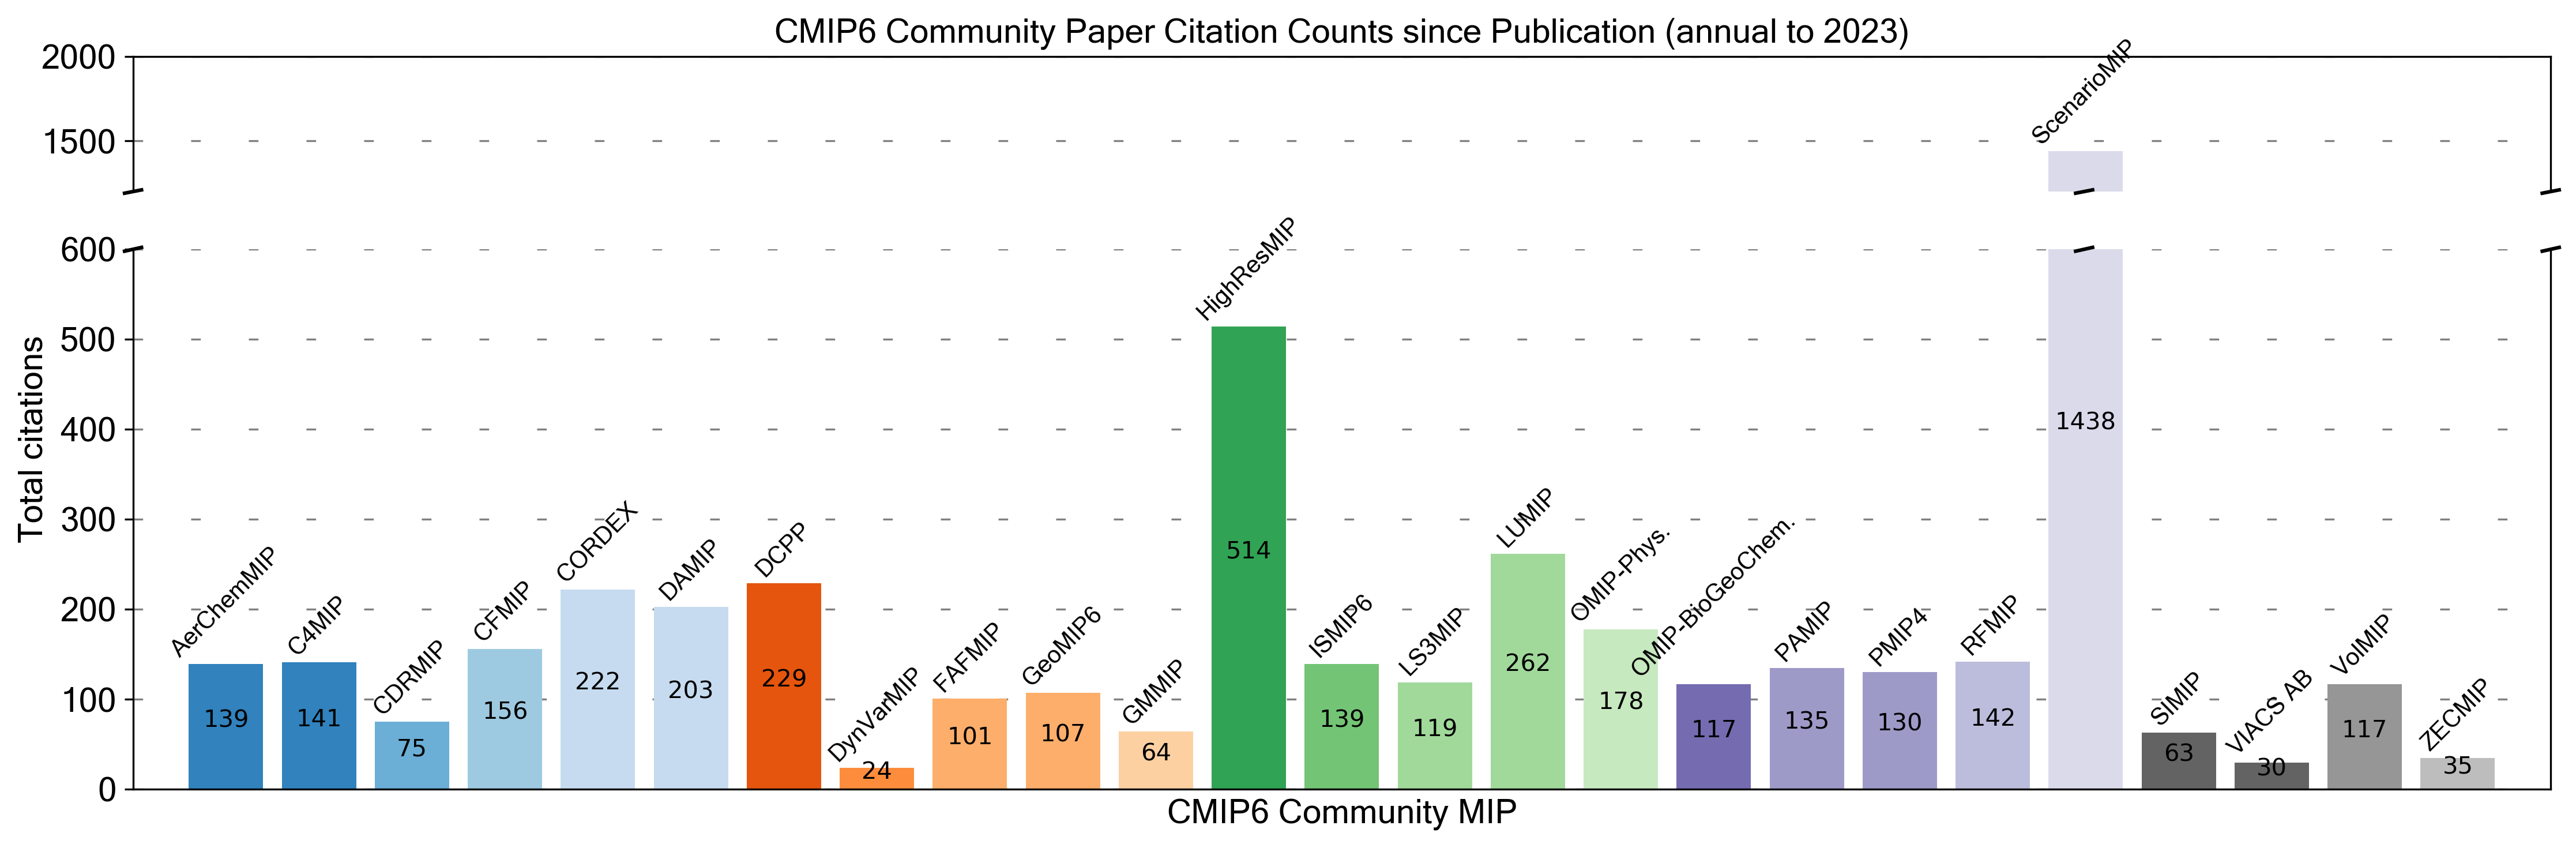

In [7]:
fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), dpi=300, ncols=1, nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 4]})

# sort axis boxes
ax1.spines[['bottom']].set_visible(False)
ax2.spines[['top']].set_visible(False)
ax1.set_ylim(1200, 2000)
ax2.set_ylim(0, 600)
ax1.set_xlim(-1, 25)
ax2.set_xlim(-1, 25)
fig.tight_layout()

# fixed values
linesty = (0, (5, 25))
rot = 45
fontname = "Microsoft Sans Serif"
fontSize = 14
fontSizeLab = 10

# create colour bins
NUM_COLORS = 26
colList = []
cm = plt.get_cmap('tab20c')  # also tab 20b, tab20
for i in range(NUM_COLORS):
    colList.append(cm(1.*i/NUM_COLORS))

val = [aerchemmip, c4mip, cdrmip, cfmip, cordex, damip, dcpp, dynvarmip, fafmip, geomip6, gmmip,
       highresmip, ismip6, ls3mip, lumip, omip1, omip2, pamip, pmip4, rfmip, scenariomip,
       simip, viacsab, volmip, zecmip]
labs = ["AerChemMIP", "C4MIP", "CDRMIP", "CFMIP", "CORDEX", "DAMIP", "DCPP",
        "DynVarMIP", "FAFMIP", "GeoMIP6", "GMMIP", "HighResMIP", "ISMIP6", "LS3MIP",
        "LUMIP", "OMIP-Phys.", "OMIP-BioGeoChem.", "PAMIP", "PMIP4", "RFMIP",
        "ScenarioMIP", "SIMIP", "VIACS AB", "VolMIP", "ZECMIP"]
valsum = []
for c,v in enumerate(val):
    tmp = np.nansum(v)
    valsum.append(tmp)

print("valsum:", valsum)
print("len(valsum):", len(valsum), "; len(labs):", len(labs))

# Start plotting
b1 = ax1.bar(labs, valsum, color=colList)
b2 = ax2.bar(labs, valsum, color=colList)
ax1.grid(zorder=0)
ax1.grid(color='gray', linestyle=linesty)
ax1.bar_label(b1, labs, label_type='edge', color='k', rotation=rot, fontsize=fontSizeLab, padding=1, zorder=10, fontname=fontname)
ax1.axes.axes.set_yticklabels(ax1.get_yticklabels(), fontsize=fontSize, fontname=fontname)
ax2.grid(zorder=0)
ax2.set_axisbelow(True)
ax2.grid(color='gray', linestyle=linesty)
ax2.bar_label(b2, labs, label_type='edge', color='k', rotation=rot, fontsize=fontSizeLab, padding=1, zorder=10, fontname=fontname)
ax2.set_ylabel("Total citations", fontsize=fontSize, fontname=fontname)
ax2.yaxis.set_label_coords(-.035, .65)
ax2.axes.axes.set_yticklabels(ax2.get_yticklabels(), fontsize=fontSize, fontname=fontname)
ax2.set_xlabel("CMIP6 Community MIP", fontsize=fontSize, fontname=fontname)
ax2.set_xticks([])
ax1.set_title("CMIP6 Community Paper Citation Counts since Publication (annual to 2023)",
             fontsize=fontSize, fontname=fontname)

# function to add value labels
f = "{:0.0f}"
def addlabels(x,y):
    for i in range(len(x)):
        y1 = f.format(y[i])
        if i == 20:
            plt.text(i, 400, y1, ha = "center")
        else:
            plt.text(i, y[i]//2, y1, ha = "center")

addlabels(labs, valsum)

# arguments to pass to plot, just so we don't keep repeating them
# following https://gist.github.com/pfandzelter/0ae861f0dee1fb4fd1d11344e3f85c9e
d = .0035  # how big to make the diagonal lines in axes coordinates
scale = 350/100  # upper scale more compressed
scenX = .807  # ScenarioMIP x-intercept
kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
ax1.plot((-d, +d), (-d*scale, +d*scale), **kwargs)  # top-left diagonal
ax1.plot((scenX - d, scenX + d), (-d*scale, +d*scale), **kwargs)  # ScenarioMIP diagonal
ax1.plot((1 - d, 1 + d), (-d*scale, +d*scale), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((scenX - d, scenX + d), (1 -d, 1 +d), **kwargs)  # ScenarioMIP diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# fill canvas
fig.tight_layout()

# display, save and close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-2b-bar.png"]))

## third plot - MIPs and composite CMIP6

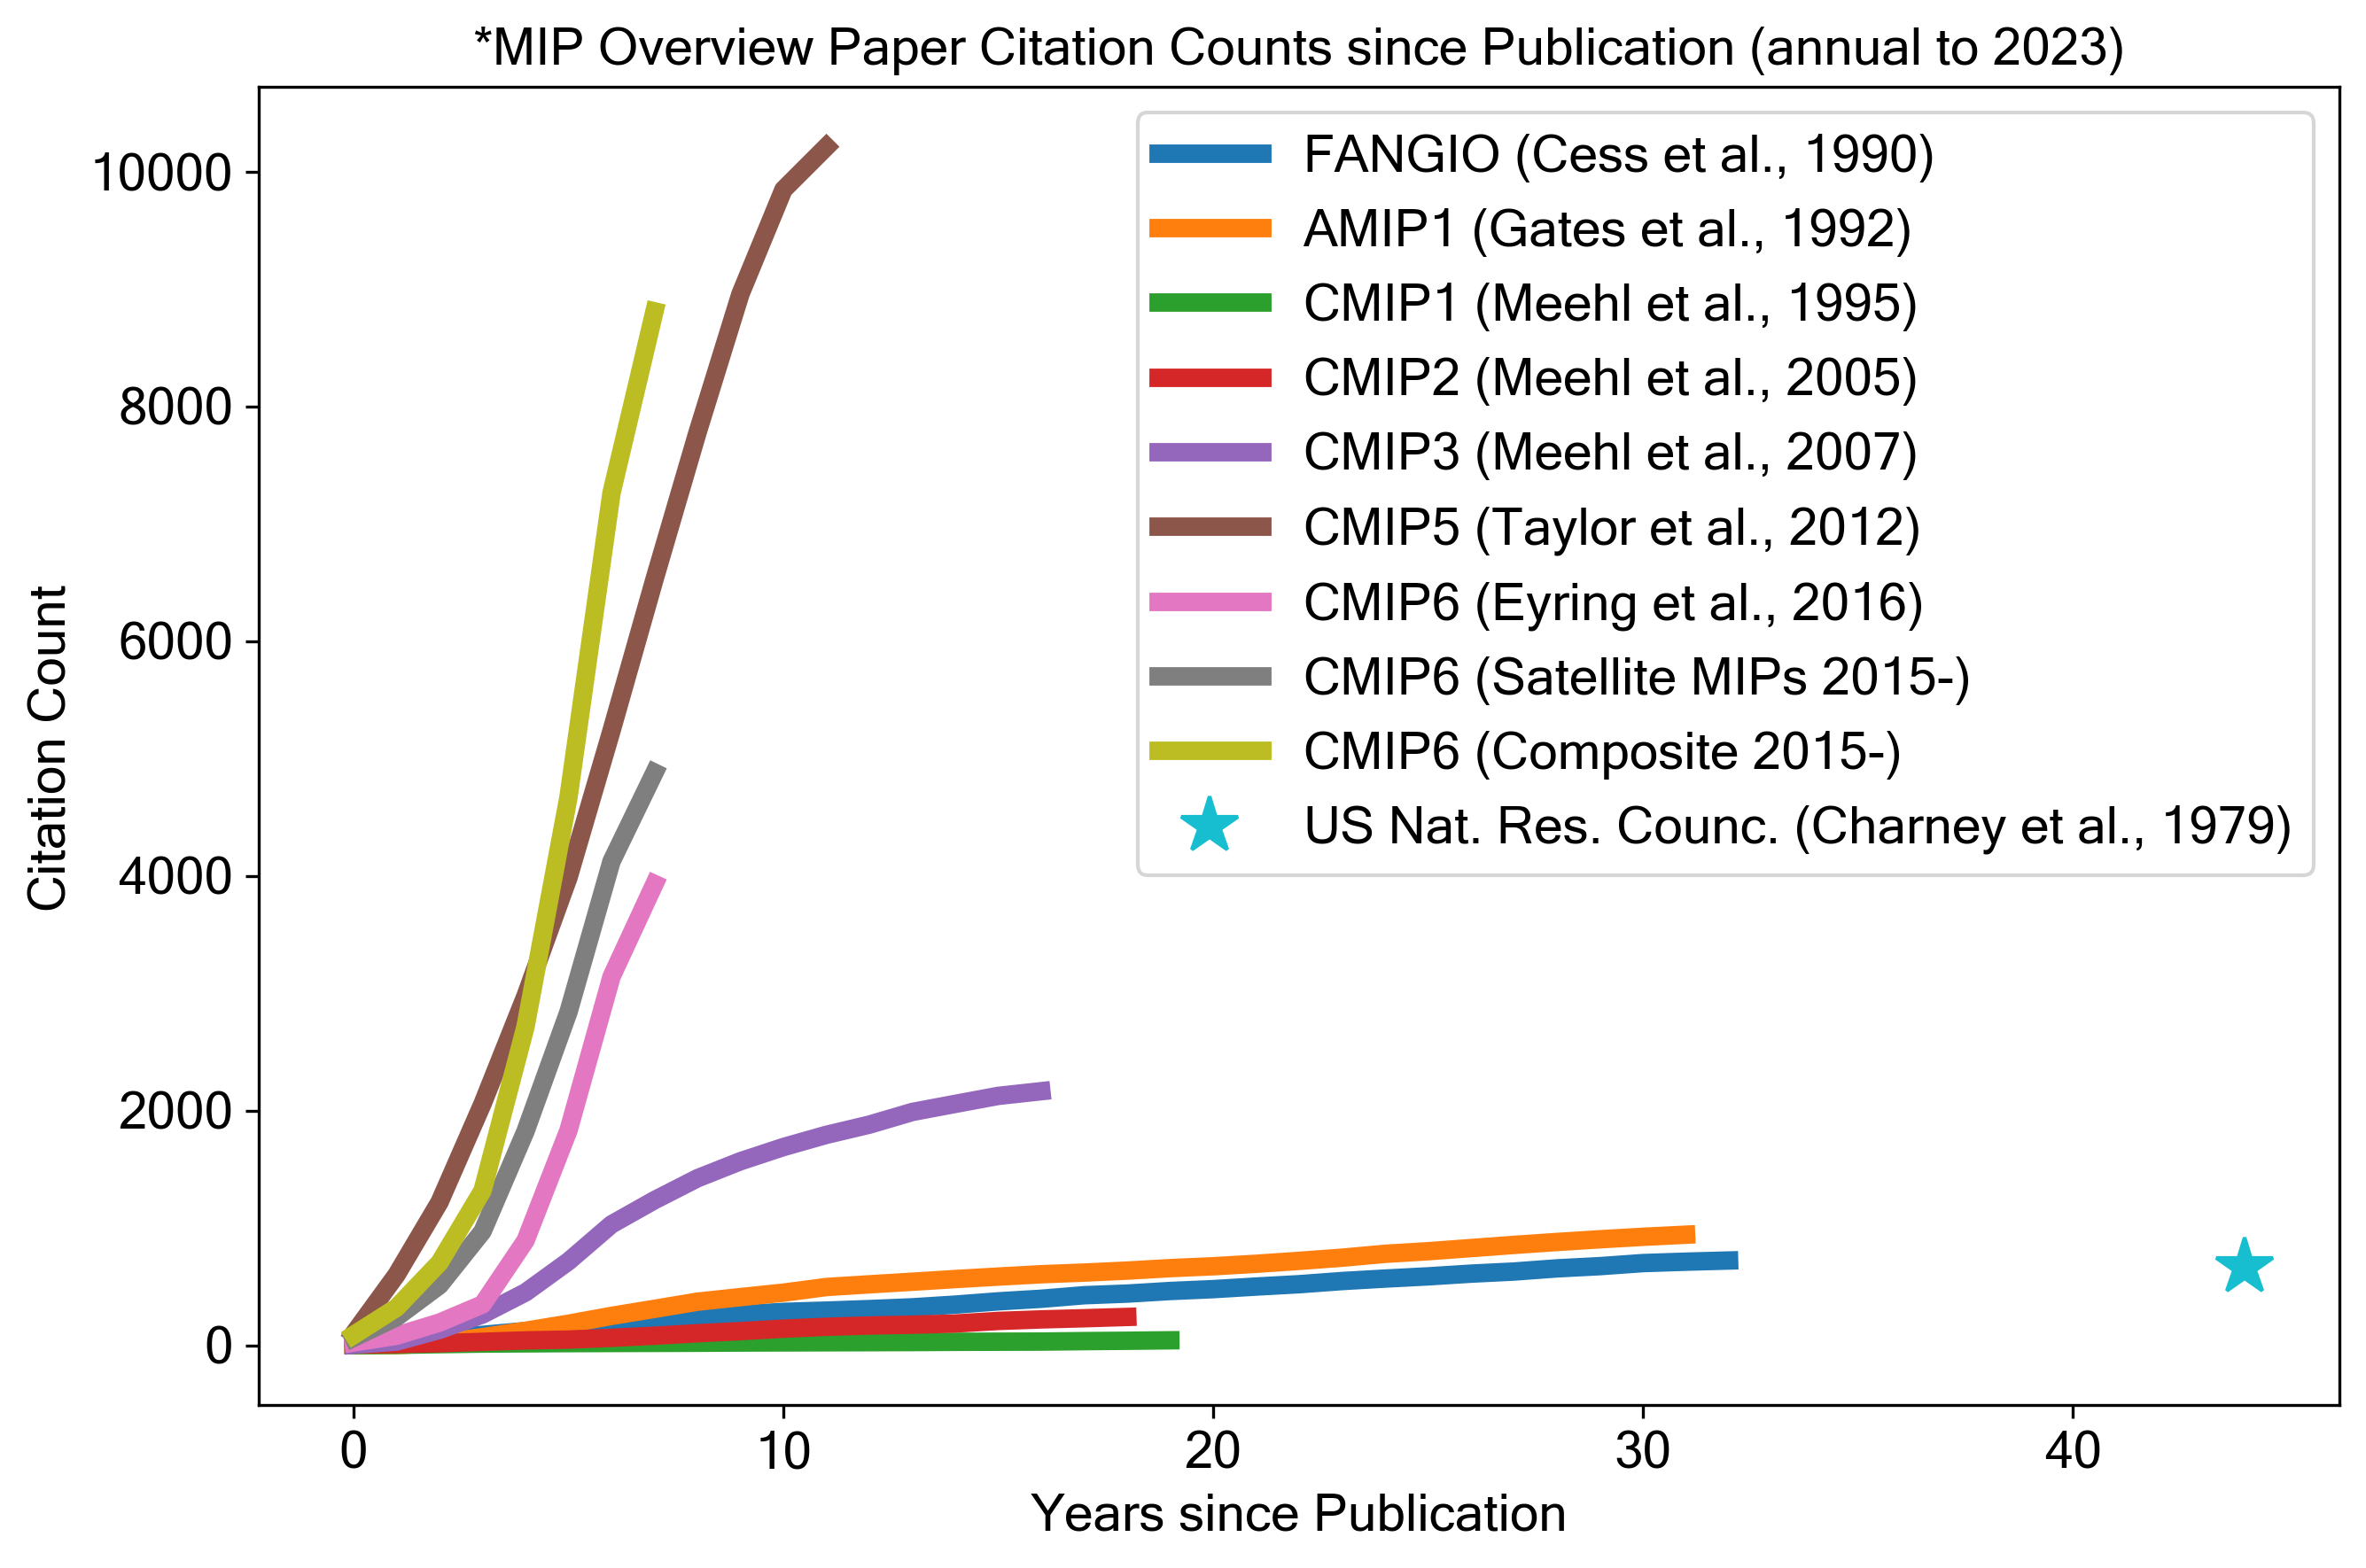

In [8]:
# Generate composite CMIP6
cmip6Comp = np.nansum([aerchemmip, c4mip, cdrmip, cfmip, cordex, damip, dcpp, dynvarmip, fafmip, geomip6, gmmip,
                       highresmip, ismip6, ls3mip, lumip, omip1, omip2, pamip, pmip4, rfmip, scenariomip,
                       simip, viacsab, volmip, zecmip], 0)
cmip6Compa = copy.deepcopy(pad)
cmip6Compa[:len(cmip6Comp)] = cmip6Comp
cmip6Comp = cmip6Compa
del(cmip6Compa)
cmip6CompA = np.nansum([cmip6, cmip6Comp], 0)
cmip6CompA = np.where(cmip6CompA == 0., np.nan, cmip6CompA)

# set inputs
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars
fontsize = 14
lineWidth = 5
fontName = "Microsoft Sans Serif"

# initialize canvas
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# plot from year 1
line0 = plt.plot(yrSincePublication, np.cumsum(fangio), linewidth=lineWidth, label="FANGIO (Cess et al., 1990)")
line1 = plt.plot(yrSincePublication, np.cumsum(amip1), linewidth=lineWidth, label="AMIP1 (Gates et al., 1992)")
line2 = plt.plot(yrSincePublication, np.cumsum(cmip1), linewidth=lineWidth, label="CMIP1 (Meehl et al., 1995)")
line3 = plt.plot(yrSincePublication, np.cumsum(cmip2), linewidth=lineWidth, label="CMIP2 (Meehl et al., 2005)")
line4 = plt.plot(yrSincePublication, np.cumsum(cmip3), linewidth=lineWidth, label="CMIP3 (Meehl et al., 2007)")
line5 = plt.plot(yrSincePublication, np.cumsum(cmip5), linewidth=lineWidth, label="CMIP5 (Taylor et al., 2012)")
line6 = plt.plot(yrSincePublication, np.cumsum(cmip6), linewidth=lineWidth, label="CMIP6 (Eyring et al., 2016)")
line7 = plt.plot(yrSincePublication, np.cumsum(cmip6Comp), linewidth=lineWidth, label="CMIP6 (Satellite MIPs 2015-)")
line8 = plt.plot(yrSincePublication, np.cumsum(cmip6CompA), linewidth=lineWidth, label="CMIP6 (Composite 2015-)")
star0 = plt.plot(2023-1979, charneyGS, marker="*", markersize=16, linestyle="None", label="US Nat. Res. Counc. (Charney et al., 1979)")

# pretty things up - add text for labels, title and custom x-axis tick labels, etc.
ax.set_title('*MIP Overview Paper Citation Counts since Publication (annual to 2023)',
             fontname=fontName, fontsize=fontsize)
ax.set_ylabel('Citation Count', fontname=fontName, fontsize=fontsize)
plt.yticks(fontname=fontName, fontsize=fontsize)
ax.set_xlabel("Years since Publication", fontname=fontName, fontsize=fontsize)
plt.xticks(fontname=fontName, fontsize=fontsize)
ax.legend(prop={"family": fontName, "size": fontsize})

# fill canvas
fig.tight_layout()

# display, save and close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-3.png"]))

# fourth plot - MIPs + CCSM4, CESM1, CESM2, E3SM-1-0

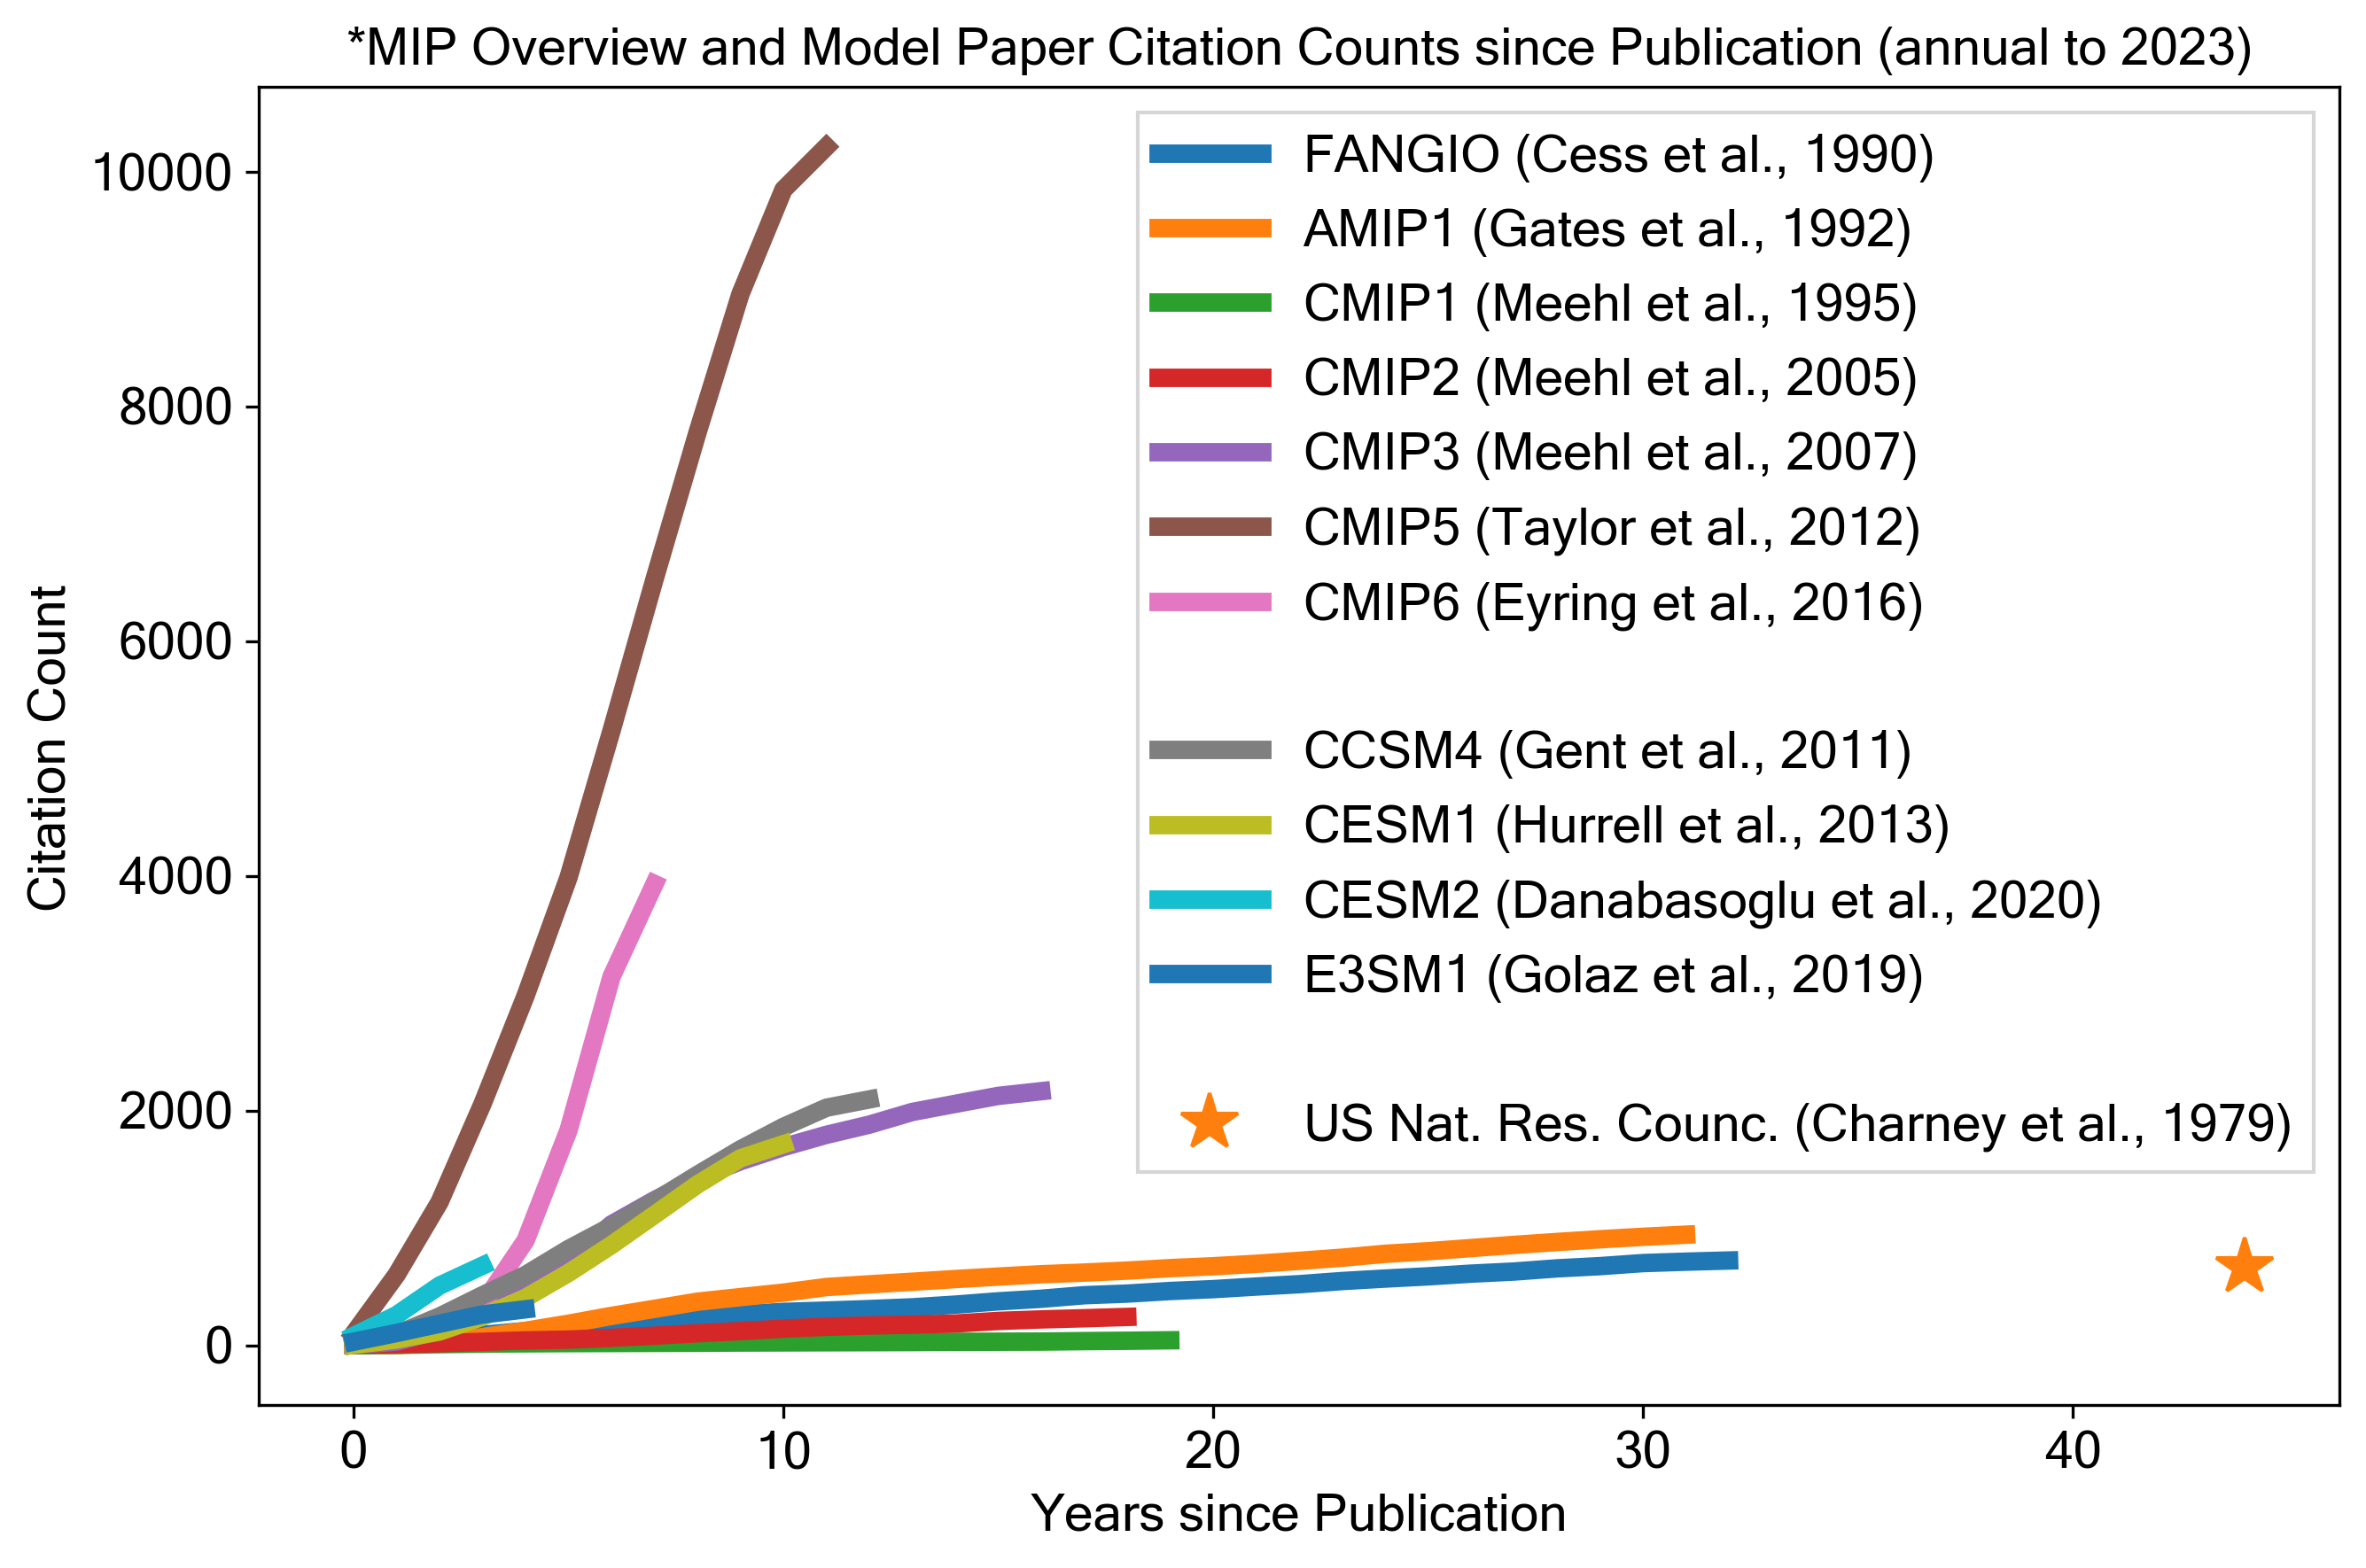

In [9]:
# set inputs
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars
fontsize = 14
lineWidth = 5
fontName = "Microsoft Sans Serif"

# initialize canvas
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# plot from year 1
line0, = plt.plot(yrSincePublication, np.cumsum(fangio), linewidth=lineWidth)
line1, = plt.plot(yrSincePublication, np.cumsum(amip1), linewidth=lineWidth)
line2, = plt.plot(yrSincePublication, np.cumsum(cmip1), linewidth=lineWidth)
line3, = plt.plot(yrSincePublication, np.cumsum(cmip2), linewidth=lineWidth)
line4, = plt.plot(yrSincePublication, np.cumsum(cmip3), linewidth=lineWidth)
line5, = plt.plot(yrSincePublication, np.cumsum(cmip5), linewidth=lineWidth)
line6, = plt.plot(yrSincePublication, np.cumsum(cmip6), linewidth=lineWidth)
line7, = plt.plot(yrSincePublication, pad, color="w")
line8, = plt.plot(yrSincePublication, np.cumsum(ccsm4), linewidth=lineWidth)
line9, = plt.plot(yrSincePublication, np.cumsum(cesm1), linewidth=lineWidth)
line10, = plt.plot(yrSincePublication, np.cumsum(cesm2), linewidth=lineWidth)
line11, = plt.plot(yrSincePublication, np.cumsum(e3sm1_0), linewidth=lineWidth)
line12, = plt.plot(yrSincePublication, pad, color="w")
star0, = plt.plot(2023-1979, charneyGS, marker="*", markersize=16, linestyle="None")

# pretty things up - add text for labels, title and custom x-axis tick labels, etc.
ax.set_title('*MIP Overview and Model Paper Citation Counts since Publication (annual to 2023)',
             fontname=fontName, fontsize=fontsize)
ax.set_ylabel('Citation Count', fontname=fontName, fontsize=fontsize)
plt.yticks(fontname=fontName, fontsize=fontsize)
ax.set_xlabel("Years since Publication", fontname=fontName, fontsize=fontsize)
plt.xticks(fontname=fontName, fontsize=fontsize)
ax.legend((line0, line1, line2, line3, line4, line5, line6, line7, line8, line9, line10, line11, line12, star0),
          ("FANGIO (Cess et al., 1990)", "AMIP1 (Gates et al., 1992)", "CMIP1 (Meehl et al., 1995)",
           "CMIP2 (Meehl et al., 2005)", "CMIP3 (Meehl et al., 2007)", "CMIP5 (Taylor et al., 2012)",
           "CMIP6 (Eyring et al., 2016)", "", "CCSM4 (Gent et al., 2011)",
           "CESM1 (Hurrell et al., 2013)", "CESM2 (Danabasoglu et al., 2020)",
           "E3SM1 (Golaz et al., 2019)", "", "US Nat. Res. Counc. (Charney et al., 1979)"),
          loc='upper right', fancybox=False, ncol=1,
          prop={"family": fontName, "size": fontsize})

# fill canvas
fig.tight_layout()

# display, save and close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-4.png"]))